![image.png](https://i.imgur.com/a3uAqnb.png)


# Fine-tuning Vision Transformer for Animal Classification: Animals10 Dataset
- **Images**: Animal photos from 10 different classes **(224x224, RGB)**
- **Classes**: 10 animal classes (dog, cat, horse, etc.) with Italian names translated to English
- **Task**: Multi-class image classification using pre-trained ViT
- **Model**: Google's ViT-Large-Patch16-224 fine-tuned for animal recognition

![Animals10 Overview](https://i.imgur.com/IS4NeFZ.png)

This notebook is heavily inspired by this [notebook](https://huggingface.co/learn/cookbook/en/fine_tuning_vit_custom_dataset)


## 🎯 **What is Vision Transformer (ViT)?**
Vision Transformer treats images as sequences of patches, similar to how text transformers process word tokens:

1️⃣ **Patch Embedding** → Split image into 16x16 patches and embed them  
2️⃣ **Position Encoding** → Add positional information to patches  
3️⃣ **Transformer Encoder** → Process patch sequences with self-attention  
4️⃣ **Classification Head** → Final layer for class prediction  

Unlike CNNs, ViT uses **attention mechanisms** to understand spatial relationships between image patches.


## 1️⃣ **Dataset Setup & Preprocessing**

### Installing Dependencies and Importing Libraries

In [1]:
# Essential libraries for ViT fine-tuning
import kagglehub  # For downloading Kaggle datasets
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Hugging Face ecosystem
from datasets import Dataset, DatasetDict, load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer

# PyTorch for deep learning
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop, Compose, Normalize, RandomHorizontalFlip,
    RandomResizedCrop, ToTensor, Resize, RandomRotation, ColorJitter
)

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Downloading the Animals10 Dataset


In [2]:
# 🔹 Download the Animals10 dataset from Kaggle
print("Downloading Animals10 dataset...")
dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/animals10


### Class Label Translation


In [3]:
# 🔹 Italian to English translation mapping for animal classes
# The Animals10 dataset uses Italian class names, so we translate them
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

## 2️⃣ **Dataset Organization & Memory Management**

### Dataset Organization Function

In [4]:
def organize_animals10_dataset(dataset_path, max_total_images=5000):
    """
    🔹 Organize the Animals10 dataset into train/validation/test splits

    Args:
        dataset_path: Path to the downloaded dataset
        max_total_images: Limit total images to reduce memory usage (important for ViT!)

    Returns:
        images: List of image file paths
        labels: List of corresponding class labels (integers)
        id2label: Dictionary mapping class IDs to English names
        label2id: Dictionary mapping English names to class IDs
    """
    raw_img_path = os.path.join(dataset_path, "raw-img")

    if not os.path.exists(raw_img_path):
        raise FileNotFoundError(f"raw-img folder not found in {dataset_path}")

    # 🔹 Get all animal classes (folder names)
    animal_classes = [d for d in os.listdir(raw_img_path)
                     if os.path.isdir(os.path.join(raw_img_path, d))]

    print(f"Found {len(animal_classes)} animal classes: {animal_classes}")
    print(f"Limiting dataset to maximum {max_total_images} images for memory efficiency")

    # 🔹 Create label mappings for the model
    id2label = {i: translate.get(cls, cls) for i, cls in enumerate(animal_classes)}
    label2id = {label: i for i, label in id2label.items()}

    # 🔹 Calculate images per class to reach the target
    images_per_class = max_total_images // len(animal_classes)

    # 🔹 Collect limited images and labels
    images = []
    labels = []

    for class_idx, class_name in enumerate(animal_classes):
        class_path = os.path.join(raw_img_path, class_name)
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # 🔹 Limit images per class for memory management
        selected_images = image_files[:images_per_class]

        print(f"Class '{class_name}' ({translate.get(class_name, class_name)}): "
              f"Using {len(selected_images)} out of {len(image_files)} images")

        for img_file in selected_images:
            img_path = os.path.join(class_path, img_file)
            images.append(img_path)
            labels.append(class_idx)

    print(f"\nTotal selected images: {len(images)}")
    return images, labels, id2label, label2id

### Hugging Face Dataset Creation


In [5]:
def create_hf_dataset(images, labels, id2label):
    """
    🔹 Create a Hugging Face dataset from image paths and labels

    This function:
    - Loads images in batches to manage memory usage
    - Resizes images to 224x224 (ViT input size)
    - Creates proper dataset features for stratified splitting

    Args:
        images: List of image file paths
        labels: List of class labels
        id2label: Class ID to name mapping

    Returns:
        Hugging Face Dataset object ready for training
    """
    from datasets import Features, Image as HFImage, ClassLabel

    print(f"Loading {len(images)} images into dataset...")

    loaded_images = []
    valid_labels = []

    # 🔹 Process images in smaller batches to avoid memory issues
    batch_size = 100
    for i in range(0, len(images), batch_size):
        print(f"Processing batch {i//batch_size + 1}/{(len(images)-1)//batch_size + 1}")

        batch_images = images[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        for img_path, label in zip(batch_images, batch_labels):
            try:
                # 🔹 Load and preprocess image
                image = Image.open(img_path).convert('RGB')  # Ensure RGB format
                # Resize to ViT input size to reduce memory footprint
                image = image.resize((224, 224), Image.Resampling.LANCZOS)
                loaded_images.append(image)
                valid_labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    print(f"Successfully loaded {len(loaded_images)} images")

    # 🔹 Define proper features with ClassLabel for stratification
    features = Features({
        'image': HFImage(),
        'label': ClassLabel(names=list(id2label.values()))
    })

    return Dataset.from_dict({
        'image': loaded_images,
        'label': valid_labels
    }, features=features)

### Execute Dataset Organization


In [6]:
# 🔹 Organize the dataset with memory limitation
# Note: ViT models require more memory than CNNs, so we limit dataset size
images, labels, id2label, label2id = organize_animals10_dataset(dataset_path, max_total_images=5000)

print(f"\nDataset Summary:")
print(f"Total images: {len(images)}")
print(f"Number of classes: {len(id2label)}")
print(f"Label mapping: {id2label}")

Found 10 animal classes: ['cavallo', 'pecora', 'elefante', 'gatto', 'scoiattolo', 'gallina', 'ragno', 'mucca', 'cane', 'farfalla']
Limiting dataset to maximum 5000 images for memory efficiency
Class 'cavallo' (horse): Using 500 out of 2623 images
Class 'pecora' (sheep): Using 500 out of 1820 images
Class 'elefante' (elephant): Using 500 out of 1446 images
Class 'gatto' (cat): Using 500 out of 1668 images
Class 'scoiattolo' (squirrel): Using 500 out of 1862 images
Class 'gallina' (chicken): Using 500 out of 3098 images
Class 'ragno' (spider): Using 500 out of 4821 images
Class 'mucca' (cow): Using 500 out of 1866 images
Class 'cane' (dog): Using 500 out of 4863 images
Class 'farfalla' (butterfly): Using 500 out of 2112 images

Total selected images: 5000

Dataset Summary:
Total images: 5000
Number of classes: 10
Label mapping: {0: 'horse', 1: 'sheep', 2: 'elephant', 3: 'cat', 4: 'squirrel', 5: 'chicken', 6: 'spider', 7: 'cow', 8: 'dog', 9: 'butterfly'}


In [7]:
# 🔹 Create the dataset with proper ClassLabel features
# This step loads all images into memory - may take a few minutes
full_dataset = create_hf_dataset(images, labels, id2label)

Loading 5000 images into dataset...
Processing batch 1/50
Processing batch 2/50
Processing batch 3/50
Processing batch 4/50
Processing batch 5/50
Processing batch 6/50
Processing batch 7/50
Processing batch 8/50
Processing batch 9/50
Processing batch 10/50
Processing batch 11/50
Processing batch 12/50
Processing batch 13/50
Processing batch 14/50
Processing batch 15/50
Processing batch 16/50
Processing batch 17/50
Processing batch 18/50
Processing batch 19/50
Processing batch 20/50
Processing batch 21/50
Processing batch 22/50
Processing batch 23/50
Processing batch 24/50
Processing batch 25/50
Processing batch 26/50
Processing batch 27/50
Processing batch 28/50
Processing batch 29/50
Processing batch 30/50
Processing batch 31/50
Processing batch 32/50
Processing batch 33/50
Processing batch 34/50
Processing batch 35/50
Processing batch 36/50
Processing batch 37/50
Processing batch 38/50
Processing batch 39/50
Processing batch 40/50
Processing batch 41/50
Processing batch 42/50
Process

## 3️⃣ **Train/Validation/Test Split**

### Stratified Dataset Splitting

In [8]:
from sklearn.model_selection import train_test_split
from datasets import DatasetDict

# Get labels as a plain list
labels = full_dataset['label']

# Create indices list
indices = list(range(len(full_dataset)))

# First split: train (70%) and temp (30%)
train_indices, temp_indices = train_test_split(
    indices, test_size=0.3, stratify=labels, random_state=42
)

# For temp split, get corresponding labels
temp_labels = [labels[i] for i in temp_indices]

# Second split: validation (15%) and test (15%) from temp
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=temp_labels, random_state=42
)

# Select subsets from the full_dataset
train_dataset = full_dataset.select(train_indices)
validation_dataset = full_dataset.select(val_indices)
test_dataset = full_dataset.select(test_indices)

# Create final DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

print(f"\nDataset splits:")
print(f"Train: {len(dataset['train'])} images")
print(f"Validation: {len(dataset['validation'])} images")
print(f"Test: {len(dataset['test'])} images")



Dataset splits:
Train: 3500 images
Validation: 750 images
Test: 750 images


## 4️⃣ **Dataset Visualization**

### Sample Visualization Function

In [9]:
def visualize_samples(dataset, id2label, num_classes=10):
    """
    🔹 Visualize one sample from each class to understand the dataset

    This helps us verify:
    - Image quality and diversity
    - Correct label mapping
    - Class balance
    """
    shown_labels = set()
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.flatten()

    sample_idx = 0
    for i, sample in enumerate(dataset['train']):
        label_id = sample['label']
        label_name = id2label[label_id]

        if label_id not in shown_labels and sample_idx < num_classes:
            axes[sample_idx].imshow(sample['image'])
            axes[sample_idx].set_title(f"{label_name} (ID: {label_id})")
            axes[sample_idx].axis('off')
            shown_labels.add(label_id)
            sample_idx += 1

        if len(shown_labels) == num_classes:
            break

    # 🔹 Hide unused subplots
    for i in range(sample_idx, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

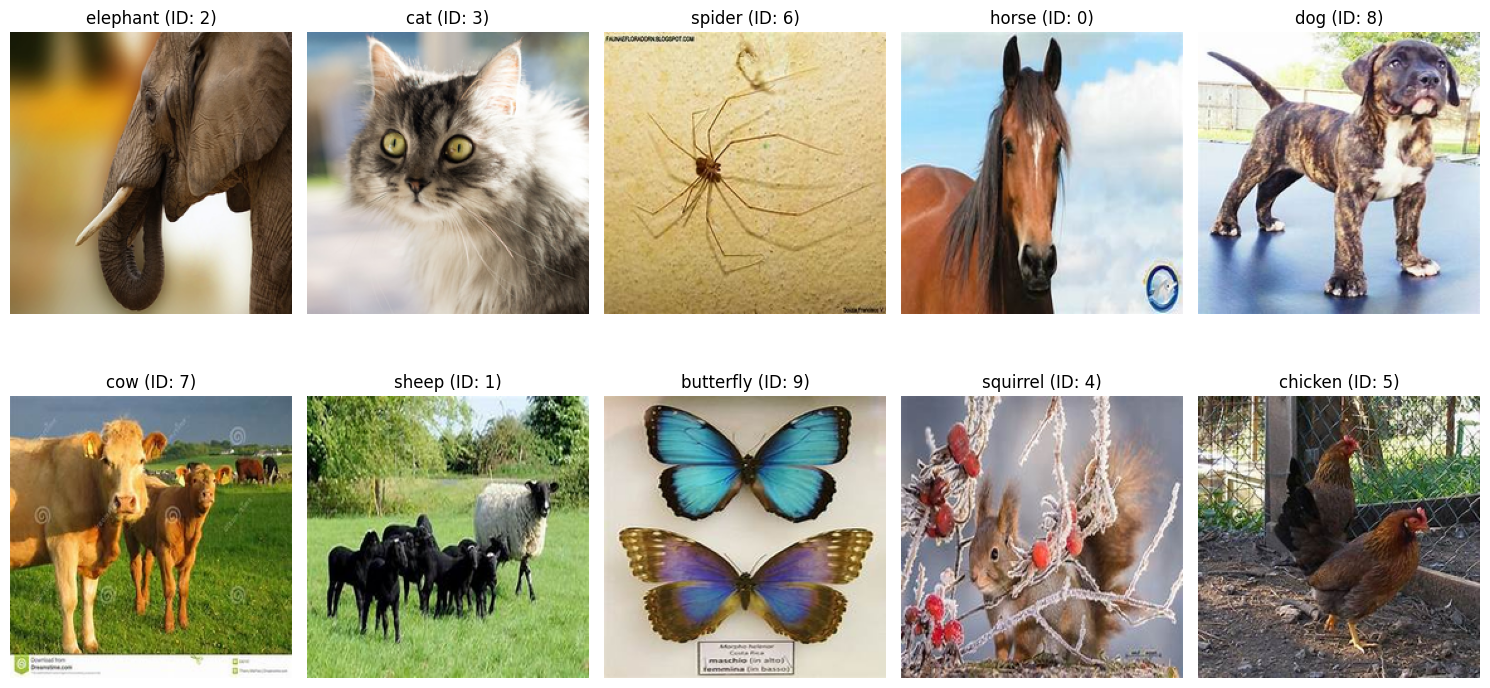

In [10]:
# 🔹 Visualize dataset samples
visualize_samples(dataset, id2label)

## 5️⃣ **Vision Transformer Setup**

### Initialize ViT Processor

In [11]:
# 🔹 Initialize the ViT processor
# This handles image preprocessing according to the pre-trained model's requirements
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

### Processor Configuration


In [12]:
# 🔹 Get processor parameters for data augmentation
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

print(f"Image size: {size}x{size}")
print(f"Image mean: {image_mean}")
print(f"Image std: {image_std}")

Image size: 224x224
Image mean: [0.5, 0.5, 0.5]
Image std: [0.5, 0.5, 0.5]


## 6️⃣ **Data Augmentation & Preprocessing**

### Define Transform Pipelines

In [13]:
# 🔹 Define transformations
# Important: Use the same normalization as the pre-trained model!
normalize = Normalize(mean=image_mean, std=image_std)

# 🔹 Enhanced data augmentation for animals
# These augmentations help the model generalize better
train_transforms = Compose([
    RandomResizedCrop(size, scale=(0.8, 1.0)),  # Random crop with scaling
    RandomHorizontalFlip(p=0.5),                # 50% chance to flip horizontally
    RandomRotation(degrees=15),                 # Small rotations
    ColorJitter(brightness=0.2, contrast=0.2,  # Color variations
               saturation=0.2, hue=0.1),
    ToTensor(),                                 # Convert to tensor
    normalize,                                  # ImageNet normalization
])

# 🔹 Validation transforms (no augmentation, just preprocessing)
val_transforms = Compose([
    Resize(size),        # Resize to model input size
    CenterCrop(size),    # Center crop to exact size
    ToTensor(),          # Convert to tensor
    normalize,           # ImageNet normalization
])

# 🔹 Test transforms (same as validation)
test_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

### Transform Application Functions


In [14]:
# 🔹 Transform functions for different dataset splits
def apply_train_transforms(examples):
    """Apply training transforms with data augmentation"""
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_val_transforms(examples):
    """Apply validation transforms without augmentation"""
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_test_transforms(examples):
    """Apply test transforms without augmentation"""
    examples['pixel_values'] = [test_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [15]:
# 🔹 Apply transforms to datasets
# set_transform applies transforms on-the-fly during training
dataset['train'].set_transform(apply_train_transforms)
dataset['validation'].set_transform(apply_val_transforms)
dataset['test'].set_transform(apply_test_transforms)
print("Transforms applied to all dataset splits")

Transforms applied to all dataset splits


## 7️⃣ **Data Loading Setup**

### Custom Collate Function

In [16]:
def collate_fn(examples):
    """
    🔹 Custom collate function for batching

    Converts list of examples into batched tensors:
    - Stacks pixel_values into batch dimension
    - Converts labels to tensor format
    """
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [17]:
# 🔹 Create data loaders with smaller batch sizes for memory efficiency
# ViT-Large requires significant GPU memory, so we use smaller batches
train_dl = DataLoader(dataset['train'], collate_fn=collate_fn, batch_size=32, shuffle=True)
val_dl = DataLoader(dataset['validation'], collate_fn=collate_fn, batch_size=32)
test_dl = DataLoader(dataset['test'], collate_fn=collate_fn, batch_size=32)

In [18]:
# 🔹 Test batch preparation to ensure everything works
batch = next(iter(train_dl))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(f"{k}: {v.shape}")

pixel_values: torch.Size([32, 3, 224, 224])
labels: torch.Size([32])


## 8️⃣ **Model Initialization**

### Load Pre-trained ViT Model

In [19]:
# 🔹 Initialize the model
# Load pre-trained ViT and adapt it for our 10-class classification task
model = ViTForImageClassification.from_pretrained(
    model_name,
    id2label=id2label,                    # Class ID to label mapping
    label2id=label2id,                    # Label to class ID mapping
    ignore_mismatched_sizes=True,         # Ignore classifier head size mismatch
    num_labels=len(id2label)             # Number of output classes
)

print(f"Model initialized with {len(id2label)} classes")
print(f"Model architecture: {model_name}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 10 classes
Model architecture: google/vit-base-patch16-224


## 9️⃣ **Training Configuration**

### Evaluation Metrics

In [20]:
def compute_metrics(eval_pred):
    """
    🔹 Compute accuracy and other metrics for evaluation

    Args:
        eval_pred: Tuple of (predictions, labels)

    Returns:
        Dictionary containing computed metrics
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  # Get predicted class

    # 🔹 Calculate various metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

### Training Arguments

In [21]:
#pip show transformers

In [22]:
# 🔹 Training arguments optimized for Animals10 (memory-efficient)
training_args = TrainingArguments(
    output_dir="./vit-animals10-finetuned",     # Model save directory
    run_name="vit-animals10-finetuned",         # Run name for TensorBoard
    report_to="none",
    save_total_limit=2,                         # Keep only 2 best checkpoints
    save_strategy="epoch",                      # Save after each epoch
    eval_strategy="epoch",                      # Evaluate after each epoch
    learning_rate=5e-5,                         # Learning rate for fine-tuning
    per_device_train_batch_size=8,              # Small batch size for memory
    per_device_eval_batch_size=8,               # Small batch size for memory
    num_train_epochs=2,                         # Number of training epochs
    weight_decay=0.01,                          # L2 regularization
    load_best_model_at_end=True,               # Load best model after training
    metric_for_best_model="accuracy",           # Metric to determine best model
    logging_dir='./logs',                       # TensorBoard logs directory
    logging_steps=25,                           # Log every 25 steps
    remove_unused_columns=False,                # Keep all dataset columns
    dataloader_num_workers=2,                   # Number of data loading workers
    warmup_steps=50,                           # Learning rate warmup steps
    gradient_accumulation_steps=2,              # Accumulate gradients over 2 steps
)

### Initialize Trainer


In [23]:
# 🔹 Initialize trainer
# The Trainer class handles the training loop, evaluation, and checkpointing
trainer = Trainer(
    model=model,                                # Our ViT model
    args=training_args,                         # Training configuration
    train_dataset=dataset['train'],             # Training data
    eval_dataset=dataset['validation'],         # Validation data
    data_collator=collate_fn,                   # Custom collate function
    tokenizer=processor,                        # Image processor (for consistency)
    compute_metrics=compute_metrics,            # Evaluation metrics function
)

/tmp/ipython-input-23-1514814126.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 🔟 **Model Training**

### Execute Training

In [24]:
# 🔹 Start training!
# This will fine-tune the pre-trained ViT on our animal classification task
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.038500,0.075041,0.986667,0.986873,0.986667,0.986674
2,0.017500,0.065972,0.986667,0.986856,0.986667,0.986674


## 1️⃣1️⃣ **Model Evaluation**
(Yes I ran out of numbers to use)
### Test Set Evaluation

In [25]:
# 🔹 Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.predict(dataset['test'])
print("Test Results:")
for metric, value in test_results.metrics.items():
    print(f"  {metric}: {value:.4f}")

Evaluating on test set...


Test Results:
  test_loss: 0.0811
  test_accuracy: 0.9773
  test_precision: 0.9779
  test_recall: 0.9773
  test_f1: 0.9773
  test_runtime: 8.1532
  test_samples_per_second: 91.9890
  test_steps_per_second: 11.5290


### Confusion Matrix Visualization


<Figure size 1200x1000 with 0 Axes>

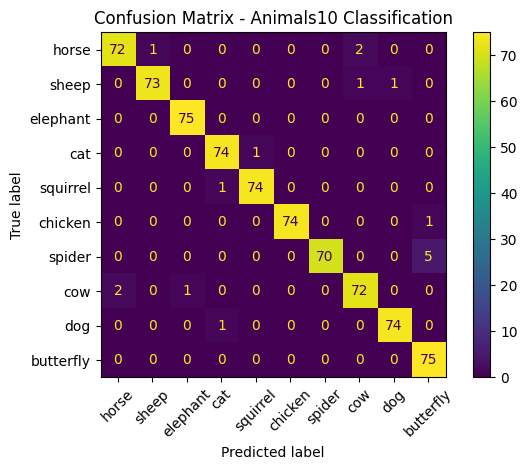

In [26]:
# 🔹 Get predictions and true labels for detailed analysis
y_true = test_results.label_ids
y_pred = test_results.predictions.argmax(axis=1)

# 🔹 Create confusion matrix
labels = [id2label[i] for i in range(len(id2label))]
cm = confusion_matrix(y_true, y_pred)

# 🔹 Plot confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, values_format='d')
plt.title('Confusion Matrix - Animals10 Classification')
plt.tight_layout()
plt.show()

### Classification Report


In [27]:
# 🔹 Print detailed classification report
print("Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

Detailed Classification Report:
              precision    recall  f1-score   support

       horse       0.97      0.96      0.97        75
       sheep       0.99      0.97      0.98        75
    elephant       0.99      1.00      0.99        75
         cat       0.97      0.99      0.98        75
    squirrel       0.99      0.99      0.99        75
     chicken       1.00      0.99      0.99        75
      spider       1.00      0.93      0.97        75
         cow       0.96      0.96      0.96        75
         dog       0.99      0.99      0.99        75
   butterfly       0.93      1.00      0.96        75

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



### Per-Class Accuracy Analysis

In [28]:
# 🔹 Calculate per-class accuracy for detailed performance analysis
print("\nPer-class Accuracy:")
for i, label in enumerate(labels):
    class_mask = (y_true == i)
    if np.sum(class_mask) > 0:
        class_acc = np.sum((y_pred == i) & class_mask) / np.sum(class_mask)
        print(f"  {label}: {class_acc:.3f}")


Per-class Accuracy:
  horse: 0.960
  sheep: 0.973
  elephant: 1.000
  cat: 0.987
  squirrel: 0.987
  chicken: 0.987
  spider: 0.933
  cow: 0.960
  dog: 0.987
  butterfly: 1.000


### **🔹 Exercise: Hyperparameter Experimentation**
Try modifying these parameters and observe the effects:
- **Learning Rate**: Try `1e-5`, `1e-4`, `5e-5`
- **Data Augmentation**: Add/remove augmentation techniques
- **Model Size**: Try `google/vit-large-patch16-224` or `convnext`(Don't kill me Eltayeb)

### Contributed by: Ali Habibullah and Yazan Alshuaibi (Fixed his "Works on my machine" problems)

<img src="https://media1.tenor.com/m/EkIUnR14JCIAAAAd/works-on-my-machine-ryan-gosling.gif" width="300" height="200" />
